In [1]:
from __future__ import print_function
import os
import torch 
from torchvision import transforms
import numpy as np

from PIL import Image

import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models

# Part 1- Model

In [2]:
def get_gram(M):
    d0, d1, d2, d3 = M.size()

    M = M.view(d0 * d1, d2 * d3)
    return torch.mm(M, M.t())
    
class Loss(nn.Module):
    def __init__(self, image, type_):
        super(Loss, self).__init__()

        self.image = image.detach()
        self.type_ = type_

    def forward(self, image_g):
        if self.type_ == 'style':
            image_G = get_gram(image_g)
            d1, d2 = image_G.size()
            self.loss = torch.mean((self.image - image_G) ** 2) / (4 * d1 *  d2 ) 
        else:
            self.loss = torch.sum((self.image - image_g) ** 2) / 2

        return image_g

In [3]:
def get_feature(model_pre, img_content, layers_c, img_style, layers_s):

    res_c = []
    res_s = []
    model = nn.Sequential()

    val_c = list(layers_c.values())
    key_c = list(layers_c.keys())

    val_s = list(layers_s.values())
    key_s = list(layers_s.keys())

    i_c = 0
    i_s = 0
    for idx, layer in enumerate(model_pre):

        if isinstance(layer, nn.MaxPool2d):
            layer = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        elif isinstance(layer, nn.ReLU):
            layer = nn.ReLU(inplace=False)

        img_content = layer(img_content)
        img_style = layer(img_style)  

        model.add_module(str(idx), layer)
        if i_c < len(val_c) and idx == val_c[i_c]: 
            loss_c = Loss(img_content.detach(), 'content')

            model.add_module("loss_content" + str(i_c), loss_c)
            res_c.append(loss_c)
            i_c += 1

        if i_s < len(val_s) and idx == val_s[i_s]: 
            target = get_gram(img_style.detach())
            loss_s = Loss(target, 'style')
            model.add_module("loss_style" + str(i_s), loss_s)
            # print(i) 
            res_s.append(loss_s)
            i_s += 1

        if i_c >= len(val_c) and i_s >= len(val_s):
            break
    return res_c, res_s, model

In [4]:
def run(model_pre, img_content, img_style, img_generated, num_steps= 100, 
        layers_c = {'conv4_2': 21}, 
        layers_s = {'conv1_1': 0, 'conv2_1': 5, 'conv3_1': 10,'conv4_1': 19,  'conv5_1': 28},
        weight_style = 10000, weight_content = 1, w_l_style = [1,1,1,1,1]):
  
    optimizer = optim.LBFGS([img_generated.requires_grad_()])
    
    c_losses, s_losses, model_new = get_feature(model_pre, img_content, layers_c, img_style, layers_s)
    # print(model_new)

    print('Optimizing..')

    for iter_num in range(num_steps):
        if iter_num % 50 == 0:
            print(iter_num)

        def closure():

            optimizer.zero_grad()
            model_new(img_generated)

            content_loss = c_losses[0].loss

            style_loss = 0
            w_l_i = 0
            for layer in s_losses:
                style_loss += w_l_style[w_l_i] * layer.loss
                w_l_i += 1
            
            loss = style_loss * weight_style + content_loss * weight_content
            # print(loss)
            loss.backward()
            return style_loss * weight_style + content_loss * weight_content

        optimizer.step(closure)

    return img_generated

# Part 2- Process Images

# 1) Images in Paper
# Read images

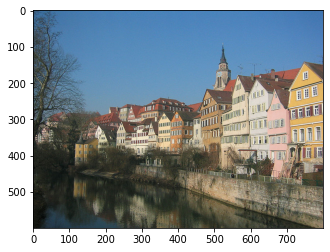

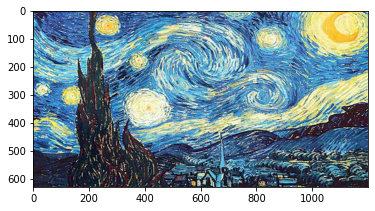

In [6]:
# read images
name_content = './im2/content.jpg'
name_style = './im2/style.jpg'

img_content = Image.open(name_content)

img_style = Image.open(name_style)

plt.figure()
plt.imshow(img_content)

plt.figure()
plt.imshow(img_style)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# PyTorch’s VGG: 1)features (containing convolution and pooling layers), 2) classifier (containing fully connected layers)
model_vgg19 = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [10]:
pre_process = transforms.Compose([
    transforms.Resize((512, 512)),  # scale imported image
    transforms.ToTensor()])  

img_content_ = pre_process(img_content).unsqueeze(0).to(device, torch.float)
img_style_ = pre_process(img_style).unsqueeze(0).to(device, torch.float)
img_generated_ = (img_content_ + img_style_) / 2
img_generated_ = img_generated_.to(device, torch.float)

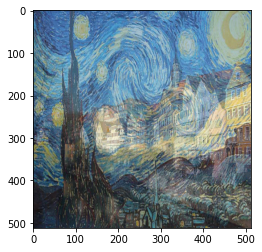

In [11]:
copy = img_generated_.data.clamp_(0, 1)
res_Image = img_generated_.cpu().clone() 
res_Image = res_Image.squeeze(0) 
unloader = transforms.ToPILImage()
res_Image = unloader(res_Image)
plt.figure()
plt.imshow(res_Image)

In [12]:
# Run

chengdu 1 5
Optimizing..
0
50


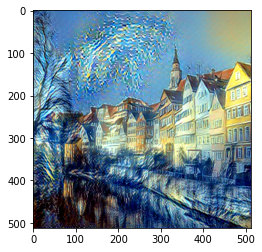

In [17]:
# im2
w_l_style = [1, 1, 1, 1, 1]

output = run(model_vgg19, img_content_, img_style_, img_generated_, num_steps= 100, weight_style=1000, weight_content = 1,  w_l_style = w_l_style )

res_Image = output.clip(0, 1)
res_Image = res_Image.cpu().clone() 
res_Image = res_Image.squeeze(0) 
unloader = transforms.ToPILImage()
res_Image = unloader(res_Image)
plt.figure()
plt.imshow(res_Image)

chengdu 1 5
Optimizing..
0
50


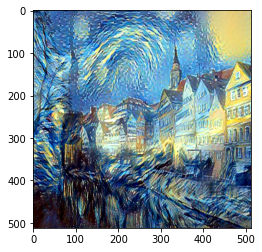

In [ ]:
# im2
w_l_style = [0.2, 0.2, 0.2, 0.2, 0.2]

output = run(model_vgg19, img_content_, img_style_, img_generated_, num_steps= 100, weight_style=1000000, weight_content = 1,  w_l_style = w_l_style )

res_Image = output.clip(0, 1)
res_Image = res_Image.cpu().clone() 
res_Image = res_Image.squeeze(0) 
unloader = transforms.ToPILImage()
res_Image = unloader(res_Image)
plt.figure()
plt.imshow(res_Image)

chengdu 1 5
Optimizing..
0
50
100
150
200
250
300
350
400
450


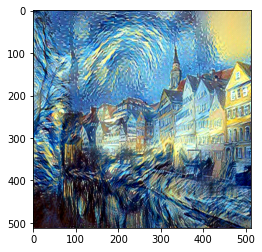

In [ ]:
# im2
w_l_style = [0.2, 0.2, 0.2, 0.2, 0.2]

output = run(model_vgg19, img_content_, img_style_, img_generated_, num_steps= 500, weight_style=1000000, weight_content = 1,  w_l_style = w_l_style )

res_Image = output.clip(0, 1)
res_Image = res_Image.cpu().clone() 
res_Image = res_Image.squeeze(0) 
unloader = transforms.ToPILImage()
res_Image = unloader(res_Image)
plt.figure()
plt.imshow(res_Image)

chengdu 1 5
Optimizing..
0
50


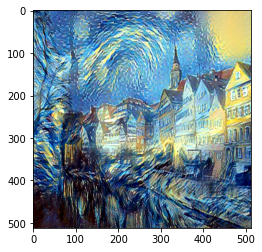

In [ ]:
w_l_style = [0.75, 0.5, 0.2, 0.2, 0.2]

output = run(model_vgg19, img_content_, img_style_, img_generated_, num_steps= 100, weight_style=1000000, weight_content = 1,  w_l_style = w_l_style )

res_Image = output.clip(0, 1)
res_Image = res_Image.cpu().clone() 
res_Image = res_Image.squeeze(0) 
unloader = transforms.ToPILImage()
res_Image = unloader(res_Image)
plt.figure()
plt.imshow(res_Image)

chengdu 1 5
Optimizing..
0
50
100
150
200
250
300
350
400
450


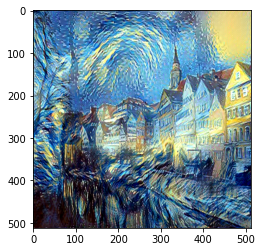

In [ ]:
w_l_style = [0.75, 0.5, 0.2, 0.2, 0.2]

output = run(model_vgg19, img_content_, img_style_, img_generated_, num_steps= 500, weight_style=1000000, weight_content = 1,  w_l_style = w_l_style )

res_Image = output.clip(0, 1)
res_Image = res_Image.cpu().clone() 
res_Image = res_Image.squeeze(0) 
unloader = transforms.ToPILImage()
res_Image = unloader(res_Image)
plt.figure()
plt.imshow(res_Image)

chengdu 1 5
Optimizing..
0
50


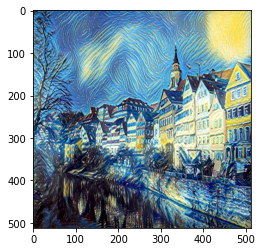

In [18]:
w_l_style = [0.75, 0.5, 0.2, 0.2, 0.2]

output = run(model_vgg19, img_content_, img_style_, img_generated_, num_steps= 100, 
             layers_c = {'conv4_2': 7},
             layers_s = {'conv1_1': 0, 'conv2_1': 2, 'conv3_1': 5,'conv4_1': 7,  'conv5_1': 10},
             weight_style=1000000, weight_content = 1,  w_l_style = w_l_style)

res_Image = output.clip(0, 1)
res_Image = res_Image.cpu().clone() 
res_Image = res_Image.squeeze(0) 
unloader = transforms.ToPILImage()
res_Image = unloader(res_Image)
plt.figure()
plt.imshow(res_Image)

chengdu 1 5
Optimizing..
0
50


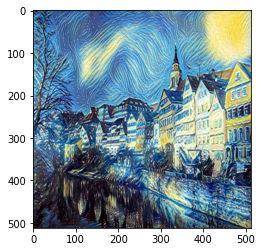

In [19]:
w_l_style = [1, 1, 1, 1, 1]

output = run(model_vgg19, img_content_, img_style_, img_generated_, num_steps= 100, 
             layers_c = {'conv4_2': 7},
             layers_s = {'conv1_1': 0, 'conv2_1': 2, 'conv3_1': 5,'conv4_1': 7,  'conv5_1': 10},
             weight_style=1000000, weight_content = 1,  w_l_style = w_l_style)

res_Image = output.clip(0, 1)
res_Image = res_Image.cpu().clone() 
res_Image = res_Image.squeeze(0) 
unloader = transforms.ToPILImage()
res_Image = unloader(res_Image)
plt.figure()
plt.imshow(res_Image)

chengdu 1 5
Optimizing..
0
50
100
150
200
250
300
350
400
450


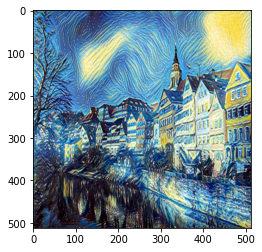

In [20]:
w_l_style = [1, 1, 1, 1, 1]

output = run(model_vgg19, img_content_, img_style_, img_generated_, num_steps= 500, 
             layers_c = {'conv4_2': 7},
             layers_s = {'conv1_1': 0, 'conv2_1': 2, 'conv3_1': 5,'conv4_1': 7,  'conv5_1': 10},
             weight_style=1000000, weight_content = 1,  w_l_style = w_l_style)

res_Image = output.clip(0, 1)
res_Image = res_Image.cpu().clone() 
res_Image = res_Image.squeeze(0) 
unloader = transforms.ToPILImage()
res_Image = unloader(res_Image)
plt.figure()
plt.imshow(res_Image)

In [26]:
# im3

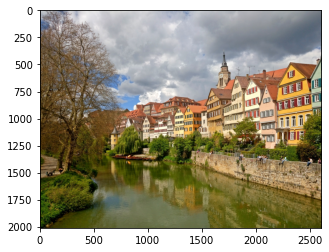

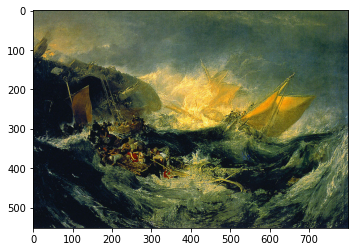

In [32]:
# read images
name_content = './im6/content.jpg'
name_style = './im6/style.jpg'

img_content = Image.open(name_content)
# img_content = sk.img_as_float(img_content)

img_style = Image.open(name_style)
# img_style = sk.img_as_float(img_style)

plt.figure()
plt.imshow(img_content)

plt.figure()
plt.imshow(img_style)

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# PyTorch’s VGG: 1)features (containing convolution and pooling layers), 2) classifier (containing fully connected layers)
model_vggim3 = models.vgg19(pretrained=True).features.to(device).eval()

In [34]:
pre_process = transforms.Compose([
    transforms.Resize((512, 512)),  # scale imported image
    transforms.ToTensor()])  

img_content_ = pre_process(img_content).unsqueeze(0).to(device, torch.float)
img_style_ = pre_process(img_style).unsqueeze(0).to(device, torch.float)
img_generated_ = (img_content_ + img_style_) / 2
img_generated_ = img_generated_.to(device, torch.float)

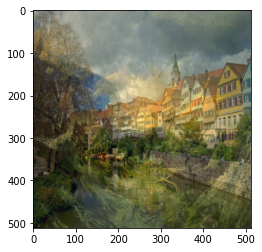

In [35]:
copy = img_generated_.data.clamp_(0, 1)
res_Image = img_generated_.cpu().clone() 
res_Image = res_Image.squeeze(0) 
unloader = transforms.ToPILImage()
res_Image = unloader(res_Image)
plt.figure()
plt.imshow(res_Image)

chengdu 1 5
Optimizing..
0
50


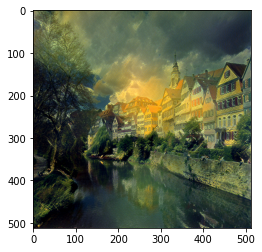

In [36]:
w_l_style = [1, 1, 1, 1, 1]

output = run(model_vggim3, img_content_, img_style_, img_generated_, num_steps= 100, 
             layers_c = {'conv4_2': 7},
             layers_s = {'conv1_1': 0, 'conv2_1': 2, 'conv3_1': 5,'conv4_1': 7,  'conv5_1': 10},
             weight_style=1000000, weight_content = 1,  w_l_style = w_l_style)

res_Image = output.clip(0, 1)
res_Image = res_Image.cpu().clone() 
res_Image = res_Image.squeeze(0) 
unloader = transforms.ToPILImage()
res_Image = unloader(res_Image)
plt.figure()
plt.imshow(res_Image)

chengdu 1 5
Optimizing..
0
50


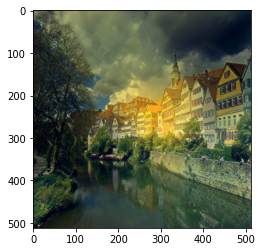

In [37]:
w_l_style = [1, 1, 1, 1, 1]

output = run(model_vggim3, img_content_, img_style_, img_generated_, num_steps= 100, 
             layers_c = {'conv4_2': 7},
             layers_s = {'conv1_1': 0, 'conv2_1': 2, 'conv3_1': 5,'conv4_1': 7,  'conv5_1': 10},
             weight_style=10000, weight_content = 1,  w_l_style = w_l_style)

res_Image = output.clip(0, 1)
res_Image = res_Image.cpu().clone() 
res_Image = res_Image.squeeze(0) 
unloader = transforms.ToPILImage()
res_Image = unloader(res_Image)
plt.figure()
plt.imshow(res_Image)

chengdu 1 5
Optimizing..
0
50


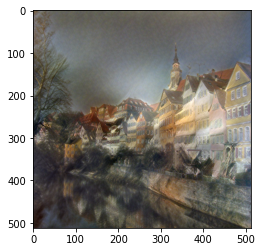

In [17]:
w_l_style = [1, 1, 1, 1, 1]

output = run(model_vggim3, img_content_, img_style_, img_generated_, num_steps= 100, 
             layers_c = {'conv4_2': 7},
             layers_s = {'conv1_1': 0, 'conv2_1': 2, 'conv3_1': 5,'conv4_1': 7,  'conv5_1': 10},
             weight_style=1000000, weight_content = 1,  w_l_style = w_l_style)

res_Image = output.clip(0, 1)
res_Image = res_Image.cpu().clone() 
res_Image = res_Image.squeeze(0) 
unloader = transforms.ToPILImage()
res_Image = unloader(res_Image)
plt.figure()
plt.imshow(res_Image)

chengdu 1 5
Optimizing..
0
50


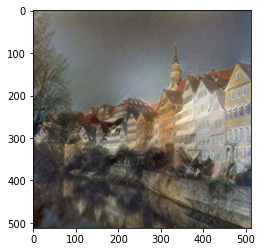

In [18]:
w_l_style = [0.75, 0.5, 0.2, 0.2, 0.2]

output = run(model_vggim3, img_content_, img_style_, img_generated_, num_steps= 100, 
             layers_c = {'conv4_2': 7},
             layers_s = {'conv1_1': 0, 'conv2_1': 2, 'conv3_1': 5,'conv4_1': 7,  'conv5_1': 10},
             weight_style=1000000, weight_content = 1,  w_l_style = w_l_style)

res_Image = output.clip(0, 1)
res_Image = res_Image.cpu().clone() 
res_Image = res_Image.squeeze(0) 
unloader = transforms.ToPILImage()
res_Image = unloader(res_Image)
plt.figure()
plt.imshow(res_Image)

chengdu 1 5
Optimizing..
0
50


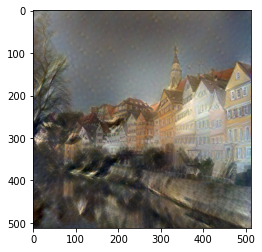

In [19]:
w_l_style = [0.75, 0.5, 0.2, 0.2, 0.2]

output = run(model_vggim3, img_content_, img_style_, img_generated_, num_steps= 100,
             weight_style=1000000, weight_content = 1,  w_l_style = w_l_style)

res_Image = output.clip(0, 1)
res_Image = res_Image.cpu().clone() 
res_Image = res_Image.squeeze(0) 
unloader = transforms.ToPILImage()
res_Image = unloader(res_Image)
plt.figure()
plt.imshow(res_Image)

chengdu 1 5
Optimizing..
0
50
100
150
200
250
300
350
400
450


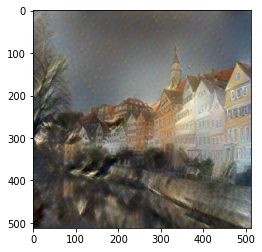

In [20]:
w_l_style = [0.75, 0.5, 0.2, 0.2, 0.2]

output = run(model_vggim3, img_content_, img_style_, img_generated_, num_steps= 500,
             weight_style=1000000, weight_content = 1,  w_l_style = w_l_style)

res_Image = output.clip(0, 1)
res_Image = res_Image.cpu().clone() 
res_Image = res_Image.squeeze(0) 
unloader = transforms.ToPILImage()
res_Image = unloader(res_Image)
plt.figure()
plt.imshow(res_Image)

In [28]:
# im4

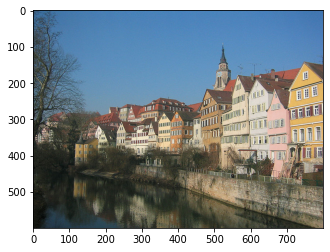

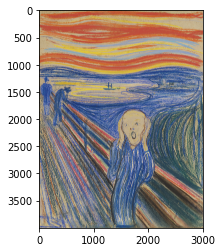

In [26]:
# read images
name_content = './im4/content.jpg'
name_style = './im4/style.jpg'

img_content = Image.open(name_content)
# img_content = sk.img_as_float(img_content)

img_style = Image.open(name_style)
# img_style = sk.img_as_float(img_style)

plt.figure()
plt.imshow(img_content)

plt.figure()
plt.imshow(img_style)

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# PyTorch’s VGG: 1)features (containing convolution and pooling layers), 2) classifier (containing fully connected layers)
model_vggim4 = models.vgg19(pretrained=True).features.to(device).eval()

In [28]:
pre_process = transforms.Compose([
    transforms.Resize((512, 512)),  # scale imported image
    transforms.ToTensor()])  

img_content_ = pre_process(img_content).unsqueeze(0).to(device, torch.float)
img_style_ = pre_process(img_style).unsqueeze(0).to(device, torch.float)
img_generated_ = (img_content_ + img_style_) / 2
img_generated_ = img_generated_.to(device, torch.float)

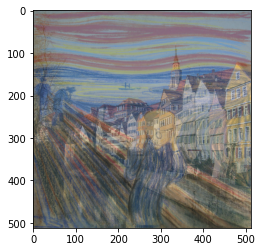

In [29]:
copy = img_generated_.data.clamp_(0, 1)
res_Image = img_generated_.cpu().clone() 
res_Image = res_Image.squeeze(0) 
unloader = transforms.ToPILImage()
res_Image = unloader(res_Image)
plt.figure()
plt.imshow(res_Image)

chengdu 1 5
Optimizing..
0
50


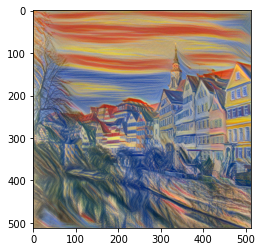

In [30]:
w_l_style = [0.75, 0.5, 0.2, 0.2, 0.2]

output = run(model_vggim4, img_content_, img_style_, img_generated_, num_steps= 100, 
             layers_c = {'conv4_2': 7},
             layers_s = {'conv1_1': 0, 'conv2_1': 2, 'conv3_1': 5,'conv4_1': 7,  'conv5_1': 10},
             weight_style=1000000, weight_content = 1,  w_l_style = w_l_style)


res_Image = output.clip(0, 1)

res_Image = res_Image.cpu().clone() 
res_Image = res_Image.squeeze(0) 
unloader = transforms.ToPILImage()
res_Image = unloader(res_Image)

plt.figure()
plt.imshow(res_Image)

In [31]:
#im5

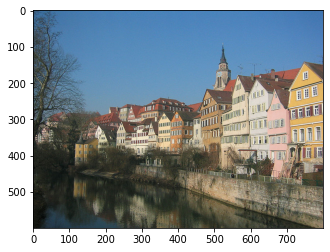

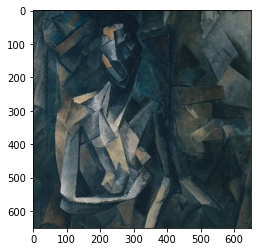

In [21]:
# read images
name_content = './im4/content.jpg'
name_style = './im1/style.jpg'

img_content = Image.open(name_content)
# img_content = sk.img_as_float(img_content)

img_style = Image.open(name_style)
# img_style = sk.img_as_float(img_style)

plt.figure()
plt.imshow(img_content)

plt.figure()
plt.imshow(img_style)

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# PyTorch’s VGG: 1)features (containing convolution and pooling layers), 2) classifier (containing fully connected layers)
model_vggim5 = models.vgg19(pretrained=True).features.to(device).eval()

In [23]:
pre_process = transforms.Compose([
    transforms.Resize((512, 512)),  # scale imported image
    transforms.ToTensor()])  

img_content_ = pre_process(img_content).unsqueeze(0).to(device, torch.float)
img_style_ = pre_process(img_style).unsqueeze(0).to(device, torch.float)
img_generated_ = (img_content_ + img_style_) / 2
img_generated_ = img_generated_.to(device, torch.float)

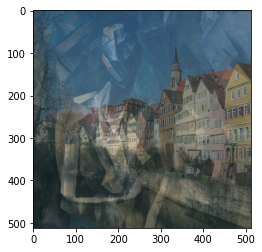

In [24]:
copy = img_generated_.data.clamp_(0, 1)
res_Image = img_generated_.cpu().clone() 
res_Image = res_Image.squeeze(0) 
unloader = transforms.ToPILImage()
res_Image = unloader(res_Image)
plt.figure()
plt.imshow(res_Image)

chengdu 1 5
Optimizing..
0
50


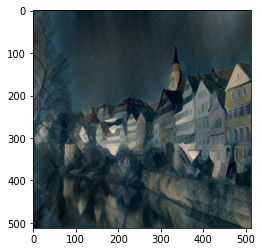

In [25]:
w_l_style = [0.75, 0.5, 0.2, 0.2, 0.2]

output = run(model_vggim5, img_content_, img_style_, img_generated_, num_steps= 100, 
             layers_c = {'conv4_2': 7},
             layers_s = {'conv1_1': 0, 'conv2_1': 2, 'conv3_1': 5,'conv4_1': 7,  'conv5_1': 10},
             weight_style=1000000, weight_content = 1,  w_l_style = w_l_style)


res_Image = output.clip(0, 1)

res_Image = res_Image.cpu().clone() 
res_Image = res_Image.squeeze(0) 
unloader = transforms.ToPILImage()
res_Image = unloader(res_Image)

plt.figure()
plt.imshow(res_Image)

# 2) More style

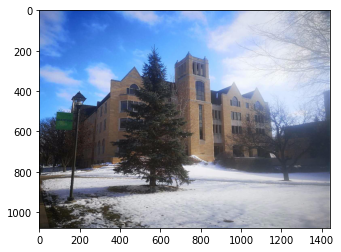

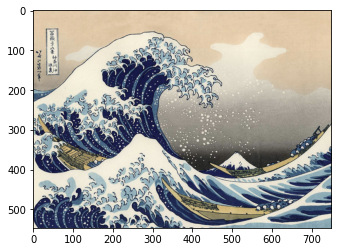

In [71]:
# read images
name_content = './im7/minn.jpg'
name_style = './im7/style.jpg'

img_content = Image.open(name_content).convert('RGB')
img_content = img_content
# img_content = sk.img_as_float(img_content)

img_style = Image.open(name_style).convert('RGB')
img_style = img_style
# img_style = sk.img_as_float(img_style)

plt.figure()
plt.imshow(img_content)

plt.figure()
plt.imshow(img_style)

In [72]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# PyTorch’s VGG: 1)features (containing convolution and pooling layers), 2) classifier (containing fully connected layers)
model_vggim7 = models.vgg19(pretrained=True).features.to(device).eval()

In [73]:
pre_process = transforms.Compose([
    transforms.Resize((512, 512)),  # scale imported image
    transforms.ToTensor()])  

img_content_ = pre_process(img_content).unsqueeze(0).to(device, torch.float)
img_style_ = pre_process(img_style).unsqueeze(0).to(device, torch.float)
img_generated_ = (img_content_ + img_style_) / 2
img_generated_ = img_generated_.to(device, torch.float)

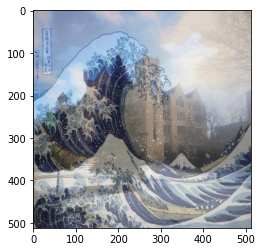

In [74]:
copy = img_generated_.data.clamp_(0, 1)
res_Image = img_generated_.cpu().clone() 
res_Image = res_Image.squeeze(0) 
unloader = transforms.ToPILImage()
res_Image = unloader(res_Image)
plt.figure()
plt.imshow(res_Image)

chengdu 1 5
Optimizing..
0
50


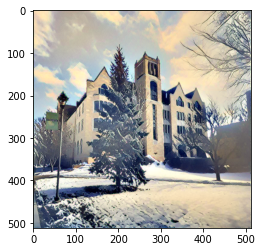

In [77]:
w_l_style = [0.75, 0.5, 0.2, 0.2, 0.2]

output = run(model_vggim7, img_content_, img_style_, img_generated_, num_steps= 500, 
             layers_c = {'conv4_2': 7},
             layers_s = {'conv1_1': 0, 'conv2_1': 2, 'conv3_1': 5,'conv4_1': 7,  'conv5_1': 10},
             weight_style=10000, weight_content = 1,  w_l_style = w_l_style)


res_Image = output.clip(0, 1)

res_Image = res_Image.cpu().clone() 
res_Image = res_Image.squeeze(0) 
unloader = transforms.ToPILImage()
res_Image = unloader(res_Image)

plt.figure()
plt.imshow(res_Image)

chengdu 1 5
Optimizing..
0
50


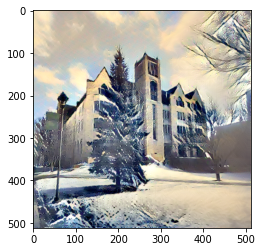

In [78]:
w_l_style = [0.75, 0.5, 0.2, 0.2, 0.2]

output = run(model_vggim7, img_content_, img_style_, img_generated_, num_steps= 100,  weight_style=10000, weight_content = 1,  w_l_style = w_l_style)


res_Image = output.clip(0, 1)

res_Image = res_Image.cpu().clone() 
res_Image = res_Image.squeeze(0) 
unloader = transforms.ToPILImage()
res_Image = unloader(res_Image)

plt.figure()
plt.imshow(res_Image)

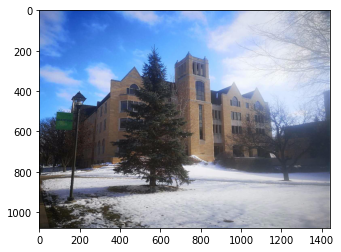

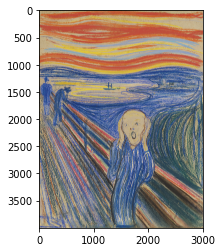

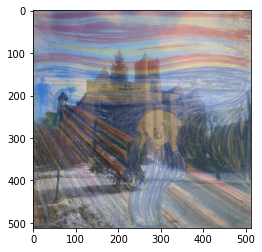

In [104]:
# read images
name_content = './im7/minn.jpg'
name_style = './im4/style.jpg'

img_content = Image.open(name_content).convert('RGB')
img_content = img_content
# img_content = sk.img_as_float(img_content)

img_style = Image.open(name_style).convert('RGB')
img_style = img_style

plt.figure()
plt.imshow(img_content)

plt.figure()
plt.imshow(img_style)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# PyTorch’s VGG: 1)features (containing convolution and pooling layers), 2) classifier (containing fully connected layers)
model_vggim8 = models.vgg19(pretrained=True).features.to(device).eval()

pre_process = transforms.Compose([
    transforms.Resize((512, 512)),  # scale imported image
    transforms.ToTensor()])  

img_content_ = pre_process(img_content).unsqueeze(0).to(device, torch.float)
img_style_ = pre_process(img_style).unsqueeze(0).to(device, torch.float)
img_generated_ = (img_content_ + img_style_) / 2
img_generated_ = img_generated_.to(device, torch.float)


copy = img_generated_.data.clamp_(0, 1)
res_Image = img_generated_.cpu().clone() 
res_Image = res_Image.squeeze(0) 
unloader = transforms.ToPILImage()
res_Image = unloader(res_Image)
plt.figure()
plt.imshow(res_Image)

chengdu 1 5
Optimizing..
0
50


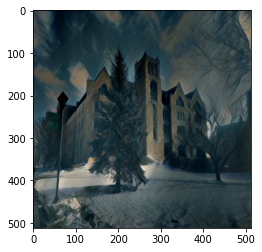

In [85]:
w_l_style = [0.75, 0.5, 0.2, 0.2, 0.2]

output = run(model_vggim8, img_content_, img_style_, img_generated_, num_steps= 100, 
             layers_c = {'conv4_2': 7},
             layers_s = {'conv1_1': 0, 'conv2_1': 2, 'conv3_1': 5,'conv4_1': 7,  'conv5_1': 10},
             weight_style=1000000, weight_content = 1,  w_l_style = w_l_style)


res_Image = output.clip(0, 1)

res_Image = res_Image.cpu().clone() 
res_Image = res_Image.squeeze(0) 
unloader = transforms.ToPILImage()
res_Image = unloader(res_Image)

plt.figure()
plt.imshow(res_Image)

chengdu 1 5
Optimizing..
0
50


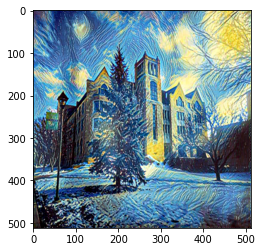

In [101]:
w_l_style = [0.75, 0.5, 0.2, 0.2, 0.2]

output = run(model_vggim8, img_content_, img_style_, img_generated_, num_steps= 100, 
             layers_c = {'conv4_2': 7},
             layers_s = {'conv1_1': 0, 'conv2_1': 2, 'conv3_1': 5,'conv4_1': 7,  'conv5_1': 10},
             weight_style=1000000, weight_content = 1,  w_l_style = w_l_style)


res_Image = output.clip(0, 1)

res_Image = res_Image.cpu().clone() 
res_Image = res_Image.squeeze(0) 
unloader = transforms.ToPILImage()
res_Image = unloader(res_Image)

plt.figure()
plt.imshow(res_Image)

chengdu 1 5
Optimizing..
0
50


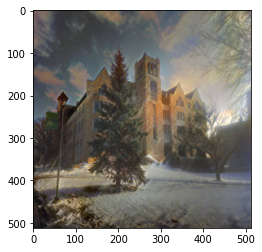

In [103]:
w_l_style = [0.75, 0.5, 0.2, 0.2, 0.2]

output = run(model_vggim8, img_content_, img_style_, img_generated_, num_steps= 100, 
             layers_c = {'conv4_2': 7},
             layers_s = {'conv1_1': 0, 'conv2_1': 2, 'conv3_1': 5,'conv4_1': 7,  'conv5_1': 10},
             weight_style=1000000, weight_content = 1,  w_l_style = w_l_style)


res_Image = output.clip(0, 1)

res_Image = res_Image.cpu().clone() 
res_Image = res_Image.squeeze(0) 
unloader = transforms.ToPILImage()
res_Image = unloader(res_Image)

plt.figure()
plt.imshow(res_Image)

chengdu 1 5
Optimizing..
0
50
100
150
200
250
300
350
400
450


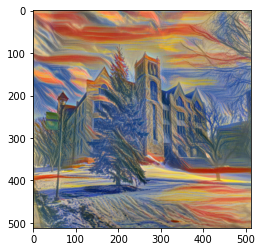

In [105]:
w_l_style = [0.75, 0.5, 0.2, 0.2, 0.2]

output = run(model_vggim8, img_content_, img_style_, img_generated_, num_steps= 500, 
             layers_c = {'conv4_2': 7},
             layers_s = {'conv1_1': 0, 'conv2_1': 2, 'conv3_1': 5,'conv4_1': 7,  'conv5_1': 10},
             weight_style=1000000, weight_content = 1,  w_l_style = w_l_style)


res_Image = output.clip(0, 1)

res_Image = res_Image.cpu().clone() 
res_Image = res_Image.squeeze(0) 
unloader = transforms.ToPILImage()
res_Image = unloader(res_Image)

plt.figure()
plt.imshow(res_Image)

# 3) More other application

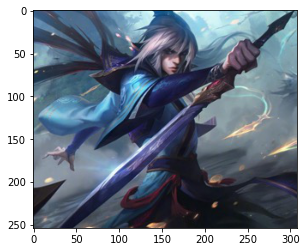

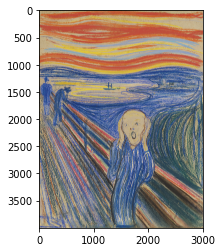

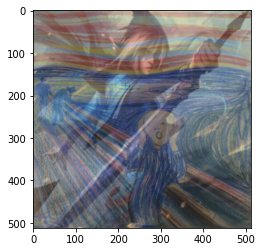

In [134]:
# read images
name_content = './im8/p1.jpg'
name_style = './im4/style.jpg'

img_content = Image.open(name_content).convert('RGB')
img_content = img_content
# img_content = sk.img_as_float(img_content)

img_style = Image.open(name_style).convert('RGB')
img_style = img_style

plt.figure()
plt.imshow(img_content)

plt.figure()
plt.imshow(img_style)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# PyTorch’s VGG: 1)features (containing convolution and pooling layers), 2) classifier (containing fully connected layers)
model_vggim8 = models.vgg19(pretrained=True).features.to(device).eval()

pre_process = transforms.Compose([
    transforms.Resize((512, 512)),  # scale imported image
    transforms.ToTensor()])  

img_content_ = pre_process(img_content).unsqueeze(0).to(device, torch.float)
img_style_ = pre_process(img_style).unsqueeze(0).to(device, torch.float)
img_generated_ = (img_content_ + img_style_) / 2
img_generated_ = img_generated_.to(device, torch.float)


copy = img_generated_.data.clamp_(0, 1)
res_Image = img_generated_.cpu().clone() 
res_Image = res_Image.squeeze(0) 
unloader = transforms.ToPILImage()
res_Image = unloader(res_Image)
plt.figure()
plt.imshow(res_Image)

chengdu 1 5
Optimizing..
0
50
100
150
200
250
300
350
400
450


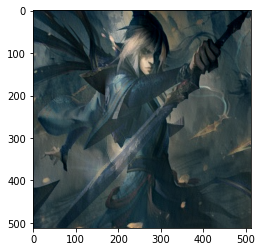

In [107]:
w_l_style = [0.75, 0.5, 0.2, 0.2, 0.2]

output = run(model_vggim8, img_content_, img_style_, img_generated_, num_steps= 500, 
             layers_c = {'conv4_2': 7},
             layers_s = {'conv1_1': 0, 'conv2_1': 2, 'conv3_1': 5,'conv4_1': 7,  'conv5_1': 10},
             weight_style=1000000, weight_content = 1,  w_l_style = w_l_style)

res_Image = output.clip(0, 1)

res_Image = res_Image.cpu().clone() 
res_Image = res_Image.squeeze(0) 
unloader = transforms.ToPILImage()
res_Image = unloader(res_Image)

plt.figure()
plt.imshow(res_Image)

chengdu 1 5
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (loss_style0): Loss()
  (1): ReLU()
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (loss_style1): Loss()
  (3): ReLU()
  (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (loss_style2): Loss()
  (6): ReLU()
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (loss_content0): Loss()
  (loss_style3): Loss()
  (8): ReLU()
  (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (loss_style4): Loss()
)
Optimizing..
0
50
100
150
200
250
300
350
400
450


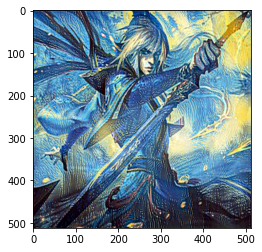

In [117]:
w_l_style = [0.75, 0.5, 0.2, 0.2, 0.2]

output = run(model_vggim8, img_content_, img_style_, img_generated_, num_steps= 500, 
             layers_c = {'conv4_2': 7},
             layers_s = {'conv1_1': 0, 'conv2_1': 2, 'conv3_1': 5,'conv4_1': 7,  'conv5_1': 10},
             weight_style=1000000, weight_content = 1,  w_l_style = w_l_style)

res_Image = output.clip(0, 1)

res_Image = res_Image.cpu().clone() 
res_Image = res_Image.squeeze(0) 
unloader = transforms.ToPILImage()
res_Image = unloader(res_Image)

plt.figure()
plt.imshow(res_Image)

In [129]:
res_Image.save('./im8/p1_3.jpg')

chengdu 1 5
Optimizing..
0
50
100
150
200
250
300
350
400
450


ValueError: ignored

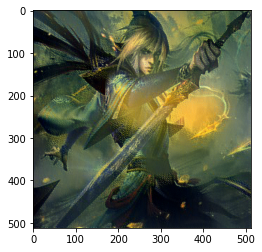

In [125]:
w_l_style = [0.75, 0.5, 0.2, 0.2, 0.2]

output = run(model_vggim8, img_content_, img_style_, img_generated_, num_steps= 500, 
             layers_c = {'conv4_2': 7},
             layers_s = {'conv1_1': 0, 'conv2_1': 2, 'conv3_1': 5,'conv4_1': 7,  'conv5_1': 10},
             weight_style=1000000, weight_content = 1,  w_l_style = w_l_style)

res_Image = output.clip(0, 1)

res_Image = res_Image.cpu().clone() 
res_Image = res_Image.squeeze(0) 
unloader = transforms.ToPILImage()
res_Image = unloader(res_Image)

plt.figure()
plt.imshow(res_Image)
res_Image.save('./im8/p1_3.jpg')

chengdu 1 5
Optimizing..
0
50
100
150
200
250
300
350
400
450


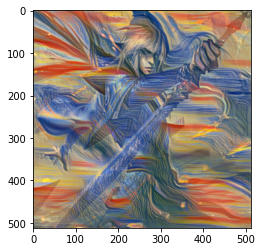

In [135]:
w_l_style = [0.75, 0.5, 0.2, 0.2, 0.2]

output = run(model_vggim8, img_content_, img_style_, img_generated_, num_steps= 500, 
             layers_c = {'conv4_2': 7},
             layers_s = {'conv1_1': 0, 'conv2_1': 2, 'conv3_1': 5,'conv4_1': 7,  'conv5_1': 10},
             weight_style=1000000, weight_content = 1,  w_l_style = w_l_style)

res_Image = output.clip(0, 1)

res_Image = res_Image.cpu().clone() 
res_Image = res_Image.squeeze(0) 
unloader = transforms.ToPILImage()
res_Image = unloader(res_Image)

plt.figure()
plt.imshow(res_Image)
res_Image.save('./im8/p1_4.jpg')

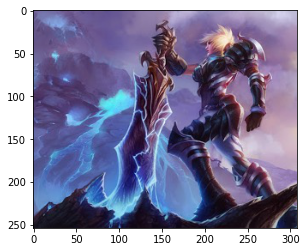

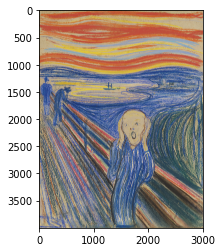

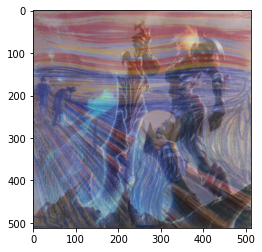

In [136]:
# read images
name_content = './im8/p2.jpg'
name_style = './im4/style.jpg'

img_content = Image.open(name_content).convert('RGB')
img_content = img_content
# img_content = sk.img_as_float(img_content)

img_style = Image.open(name_style).convert('RGB')
img_style = img_style

plt.figure()
plt.imshow(img_content)

plt.figure()
plt.imshow(img_style)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# PyTorch’s VGG: 1)features (containing convolution and pooling layers), 2) classifier (containing fully connected layers)
model_vggim9 = models.vgg19(pretrained=True).features.to(device).eval()

pre_process = transforms.Compose([
    transforms.Resize((512, 512)),  # scale imported image
    transforms.ToTensor()])  

img_content_ = pre_process(img_content).unsqueeze(0).to(device, torch.float)
img_style_ = pre_process(img_style).unsqueeze(0).to(device, torch.float)
img_generated_ = (img_content_ + img_style_) / 2
img_generated_ = img_generated_.to(device, torch.float)


copy = img_generated_.data.clamp_(0, 1)
res_Image = img_generated_.cpu().clone() 
res_Image = res_Image.squeeze(0) 
unloader = transforms.ToPILImage()
res_Image = unloader(res_Image)
plt.figure()
plt.imshow(res_Image)

chengdu 1 5
Optimizing..
0
50
100
150
200
250
300
350
400
450


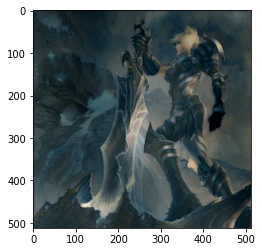

In [109]:
w_l_style = [0.75, 0.5, 0.2, 0.2, 0.2]

output = run(model_vggim9, img_content_, img_style_, img_generated_, num_steps= 500, 
             layers_c = {'conv4_2': 7},
             layers_s = {'conv1_1': 0, 'conv2_1': 2, 'conv3_1': 5,'conv4_1': 7,  'conv5_1': 10},
             weight_style=1000000, weight_content = 1,  w_l_style = w_l_style)

res_Image = output.clip(0, 1)

res_Image = res_Image.cpu().clone() 
res_Image = res_Image.squeeze(0) 
unloader = transforms.ToPILImage()
res_Image = unloader(res_Image)

plt.figure()
plt.imshow(res_Image)

chengdu 1 5
Optimizing..
0
50
100
150
200
250
300
350
400
450


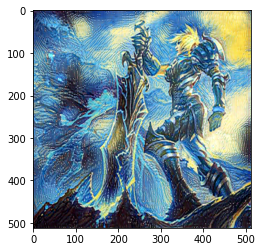

In [120]:
w_l_style = [0.75, 0.5, 0.2, 0.2, 0.2]

output = run(model_vggim9, img_content_, img_style_, img_generated_, num_steps= 500, 
             layers_c = {'conv4_2': 7},
             layers_s = {'conv1_1': 0, 'conv2_1': 2, 'conv3_1': 5,'conv4_1': 7,  'conv5_1': 10},
             weight_style=1000000, weight_content = 1,  w_l_style = w_l_style)

res_Image = output.clip(0, 1)

res_Image = res_Image.cpu().clone() 
res_Image = res_Image.squeeze(0) 
unloader = transforms.ToPILImage()
res_Image = unloader(res_Image)

plt.figure()
plt.imshow(res_Image)

chengdu 1 5
Optimizing..
0
50
100
150
200
250
300
350
400
450


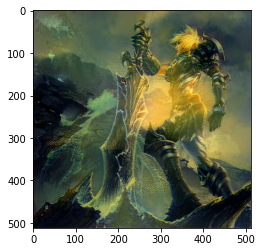

In [131]:
w_l_style = [0.75, 0.5, 0.2, 0.2, 0.2]

output = run(model_vggim9, img_content_, img_style_, img_generated_, num_steps= 500, 
             layers_c = {'conv4_2': 7},
             layers_s = {'conv1_1': 0, 'conv2_1': 2, 'conv3_1': 5,'conv4_1': 7,  'conv5_1': 10},
             weight_style=1000000, weight_content = 1,  w_l_style = w_l_style)

res_Image = output.clip(0, 1)

res_Image = res_Image.cpu().clone() 
res_Image = res_Image.squeeze(0) 
unloader = transforms.ToPILImage()
res_Image = unloader(res_Image)

plt.figure()
plt.imshow(res_Image)
res_Image.save('./im8/p2_3.jpg')

chengdu 1 5
Optimizing..
0
50
100
150
200
250
300
350
400
450


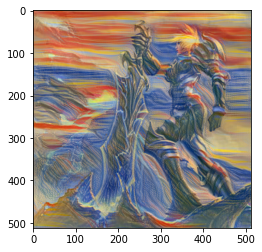

In [137]:
w_l_style = [0.75, 0.5, 0.2, 0.2, 0.2]

output = run(model_vggim9, img_content_, img_style_, img_generated_, num_steps= 500, 
             layers_c = {'conv4_2': 7},
             layers_s = {'conv1_1': 0, 'conv2_1': 2, 'conv3_1': 5,'conv4_1': 7,  'conv5_1': 10},
             weight_style=1000000, weight_content = 1,  w_l_style = w_l_style)

res_Image = output.clip(0, 1)

res_Image = res_Image.cpu().clone() 
res_Image = res_Image.squeeze(0) 
unloader = transforms.ToPILImage()
res_Image = unloader(res_Image)

plt.figure()
plt.imshow(res_Image)
res_Image.save('./im8/p2_4.jpg')

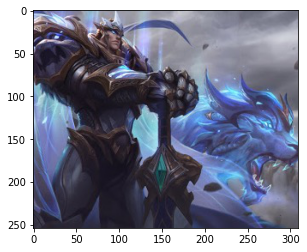

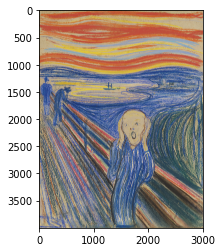

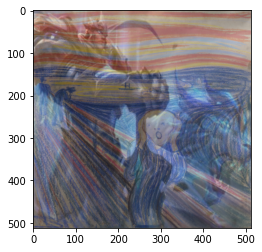

In [138]:
# read images
name_content = './im8/p3.jpg'
name_style = './im4/style.jpg'

img_content = Image.open(name_content).convert('RGB')
img_content = img_content
# img_content = sk.img_as_float(img_content)

img_style = Image.open(name_style).convert('RGB')
img_style = img_style

plt.figure()
plt.imshow(img_content)

plt.figure()
plt.imshow(img_style)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# PyTorch’s VGG: 1)features (containing convolution and pooling layers), 2) classifier (containing fully connected layers)
model_vggim10 = models.vgg19(pretrained=True).features.to(device).eval()

pre_process = transforms.Compose([
    transforms.Resize((512, 512)),  # scale imported image
    transforms.ToTensor()])  

img_content_ = pre_process(img_content).unsqueeze(0).to(device, torch.float)
img_style_ = pre_process(img_style).unsqueeze(0).to(device, torch.float)
img_generated_ = (img_content_ + img_style_) / 2
img_generated_ = img_generated_.to(device, torch.float)


copy = img_generated_.data.clamp_(0, 1)
res_Image = img_generated_.cpu().clone() 
res_Image = res_Image.squeeze(0) 
unloader = transforms.ToPILImage()
res_Image = unloader(res_Image)
plt.figure()
plt.imshow(res_Image)

chengdu 1 5
Optimizing..
0
50
100
150
200
250
300
350
400
450


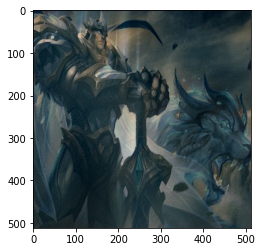

In [111]:
w_l_style = [0.75, 0.5, 0.2, 0.2, 0.2]

output = run(model_vggim10, img_content_, img_style_, img_generated_, num_steps= 500, 
             layers_c = {'conv4_2': 7},
             layers_s = {'conv1_1': 0, 'conv2_1': 2, 'conv3_1': 5,'conv4_1': 7,  'conv5_1': 10},
             weight_style=1000000, weight_content = 1,  w_l_style = w_l_style)

res_Image = output.clip(0, 1)

res_Image = res_Image.cpu().clone() 
res_Image = res_Image.squeeze(0) 
unloader = transforms.ToPILImage()
res_Image = unloader(res_Image)

plt.figure()
plt.imshow(res_Image)

chengdu 1 5
Optimizing..
0
50
100
150
200
250
300
350
400
450


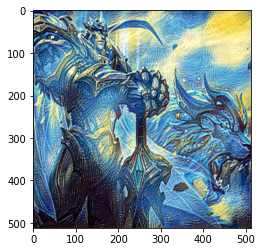

In [122]:
w_l_style = [0.75, 0.5, 0.2, 0.2, 0.2]

output = run(model_vggim10, img_content_, img_style_, img_generated_, num_steps= 500, 
             layers_c = {'conv4_2': 7},
             layers_s = {'conv1_1': 0, 'conv2_1': 2, 'conv3_1': 5,'conv4_1': 7,  'conv5_1': 10},
             weight_style=1000000, weight_content = 1,  w_l_style = w_l_style)

res_Image = output.clip(0, 1)

res_Image = res_Image.cpu().clone() 
res_Image = res_Image.squeeze(0) 
unloader = transforms.ToPILImage()
res_Image = unloader(res_Image)

plt.figure()
plt.imshow(res_Image)

chengdu 1 5
Optimizing..
0
50
100
150
200
250
300
350
400
450


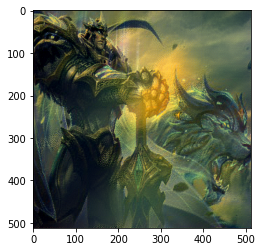

In [133]:
w_l_style = [0.75, 0.5, 0.2, 0.2, 0.2]

output = run(model_vggim10, img_content_, img_style_, img_generated_, num_steps= 500, 
             layers_c = {'conv4_2': 7},
             layers_s = {'conv1_1': 0, 'conv2_1': 2, 'conv3_1': 5,'conv4_1': 7,  'conv5_1': 10},
             weight_style=1000000, weight_content = 1,  w_l_style = w_l_style)

res_Image = output.clip(0, 1)

res_Image = res_Image.cpu().clone() 
res_Image = res_Image.squeeze(0) 
unloader = transforms.ToPILImage()
res_Image = unloader(res_Image)

plt.figure()
plt.imshow(res_Image)
res_Image.save('./im8/p3_3.jpg')

chengdu 1 5
Optimizing..
0
50
100
150
200
250
300
350
400
450


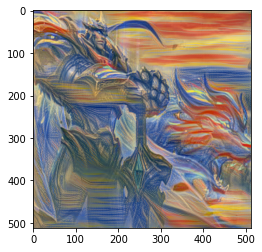

In [139]:
w_l_style = [0.75, 0.5, 0.2, 0.2, 0.2]

output = run(model_vggim10, img_content_, img_style_, img_generated_, num_steps= 500, 
             layers_c = {'conv4_2': 7},
             layers_s = {'conv1_1': 0, 'conv2_1': 2, 'conv3_1': 5,'conv4_1': 7,  'conv5_1': 10},
             weight_style=1000000, weight_content = 1,  w_l_style = w_l_style)

res_Image = output.clip(0, 1)

res_Image = res_Image.cpu().clone() 
res_Image = res_Image.squeeze(0) 
unloader = transforms.ToPILImage()
res_Image = unloader(res_Image)

plt.figure()
plt.imshow(res_Image)
res_Image.save('./im8/p3_4.jpg')